# **PREDICTING BANK PRODUCT SUBSCRIPTION**

## Big Data Intelligence Project

**Authors:**  
Diego Rivera Suárez  
Alfonso Delgado Lara


## Introduction

The objective of this project is to predict whether a bank customer will subscribe to a term deposit based on demographic, financial and interaction-related information. This is a supervised binary
classification problem, where the target variable indicates whether the client accepts the product after
being contacted by the bank.

The analysis follows a complete machine learning workflow, including data preprocessing, feature
engineering, model training, hyper-parameter tuning and performance evaluation. Both baseline and
advanced machine learning models are explored in order to assess their predictive capabilities and
robustness.

## Libraries and Tools

For this project, we used several Python libraries for data manipulation, visualization, machine learning
and model interpretation.

- **NumPy** and **Pandas**: for handling data and numerical computations.  
- **Matplotlib**: to create plots and visualize results.  
- **Scikit-learn**: provides tools for preprocessing (imputation, scaling, encoding), building pipelines,
  and training basic models like K-Nearest Neighbors, Decision Trees, Random Forests, and Extra Trees.  
  It also helps with evaluating models using cross-validation and metrics.  
- **XGBoost**, **CatBoost**, and **HistGradientBoosting**: advanced gradient boosting models that usually
  perform well on tabular data.  
- **Optuna**: for tuning model hyper-parameters automatically.
- **Statsmodels**: to perform some statistical analysis like calculating confidence intervals.
- **Joblib**: to save trained models so they can be reused later without retraining.   
- **SHAP**: to visualize the importance of features in the predictions, especially for CatBoost models.  

These libraries allow us to create a complete machine learning workflow, from preprocessing the data
to training, evaluating, tuning, and interpreting the models.


In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score
import optuna
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.proportion import proportion_confint
import joblib
import shap

## **EDA (Exploratory Data Analysis)**

In this section, we perform a simplified exploratory data analysis (EDA) to understand the dataset,
its features, and prepare it for machine learning. We aim to check:
- The number of features and instances
- Which variables are categorical or numerical
- High-cardinality categorical variables
- Missing values and constant columns
- Whether the target is balanced
- How to preprocess the `pdays` variable



First, we load the bank information dataset into a Pandas DataFrame and take a quick look at the first rows to understand its structure.


In [2]:
df = pd.read_pickle("/content/bank_92.pkl")
df.head()



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Before diving into detailed analysis, it is important to get some basic information about the dataset. Checking the number of instances (rows) and features (columns) provides an initial understanding
of the dataset's size and dimensionality.


In [3]:
#number of instances
n_instances=df.shape[0]
print("Number of instances:", n_instances)

#number of features
n_features=df.shape[1]
print("\nNumber of features:", n_features)

Number of instances: 11000

Number of features: 17


The dataset contains both numerical and categorical variables. Identifying the type of each feature
is essential to apply the appropriate preprocessing techniques. Additionally, categorical features
with a very high number of unique values (high cardinality) may require special preprocessing,
such as encoding strategies that avoid generating too many dummy variables.


In [4]:
#categorical variables
var_categorical = df.select_dtypes(include=['object']).columns

#numerical variables
var_numerical = df.select_dtypes(include=['int64', 'float64']).columns

print("\nNumerical features:", list(var_numerical))
print("\nCategorical features:", list(var_categorical))

#Count unique values per categorical feature
n_unique = df[var_categorical].nunique().sort_values(ascending=False)

print("\nNumber of unique values per categorical feature:")
display(n_unique.reset_index().rename(columns={'index': 'Feature', 0: 'Unique Values'}))

#Define high cardinality threshold for medium dataset (10000–100000 instances)
threshold = 30

#Identify high-cardinality features
high_cardinality = n_unique[n_unique > threshold]

if not high_cardinality.empty:
    print("\nHigh-cardinality categorical features (more than 50 unique values):")
    display(
        high_cardinality
        .reset_index()
        .rename(columns={'index': 'Feature', 0: 'Unique Values'})
    )
else:
    print("\nNo high-cardinality categorical features (all have 50 or fewer unique values).")


Numerical features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

Number of unique values per categorical feature:


,Feature,Unique Values
0,job,12
1,month,12
2,poutcome,4
3,education,4
4,marital,3
5,contact,3
6,loan,2
7,housing,2
8,default,2
9,deposit,2



No high-cardinality categorical features (all have 50 or fewer unique values).


After examining the categorical features, it is observed that none of them have a high number of unique values,
so no special high-cardinality encoding techniques are required at this stage.  

Next, some categorical variables are inspected individually to check for unusual or placeholder values.
The variables `contact`, `education` and `poutcome` contain the value `unknown`, which represents missing or
unrecorded information. These values are kept as `unknown`, since they represent a meaningful category in the dataset and
will be handled explicitly during the preprocessing stage of the machine learning pipelines.



In [5]:
#Examine unique values of selected categorical variables
print(df['contact'].unique())
print(df['education'].unique())
print(df['poutcome'].unique())

['unknown' 'cellular' 'telephone']
['secondary' 'tertiary' 'primary' 'unknown']
['unknown' 'other' 'failure' 'success']


The dataset is checked for missing values in all features. Identifying missing data is essential because it allows the preprocessing pipeline to handle these cases correctly. The following code counts the missing values per feature and displays only the features that contain missing entries.


In [6]:
# Missing values for each feature
missing_counts = df.isna().sum()

# Filter only columns with missing values
features_with_missing = missing_counts[missing_counts > 0]

# Display features with the number of missing values if they exist
if features_with_missing.empty:
    print("There is no missing value in the dataset.")
else:
    missing_df = features_with_missing.reset_index()
    missing_df.columns = ["Feature", "number of missing counts"]
    display(missing_df.sort_values(by="number of missing counts", ascending=False))

,Feature,number of missing counts
1,marital,182
0,job,106


Next, the dataset is examined for constant and ID columns. Constant columns have the same value for all instances and do not provide useful information for machine learning models. ID columns contain unique values for each row and usually serve only as identifiers. They should be removed from the feature set to avoid introducing noise or misleading patterns. The following code detects
both types of columns.


In [7]:
#Check for constant columns
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
if constant_cols:
    print("Constant columns:", constant_cols)
else:
    print("There is no constant column in the dataset.")

#Check for ID-like columns
id_cols = [col for col in df.columns if df[col].nunique() == len(df)]
if id_cols:
    print("ID columns:", id_cols)
else:
    print("There is no ID column in the dataset.")

There is no constant column in the dataset.
There is no ID column in the dataset.


It is seen that the dataset contains neither constant columns nor ID columns, which means that all features potentially provide useful information for modeling. The next step is to analyze the response variable `deposit`. This includes checking its data type, the number of unique values, and determining whether the problem is a classification or regression task.


In [8]:
# Check type and number of unique values
print("Response variable type:", df['deposit'].dtype)
print("Number of unique values of the response variable:", df['deposit'].nunique())

if df['deposit'].dtype == 'object':
    problem_type = "classification"
else:
    problem_type = "regression"

print(f"The problem type is {problem_type}.")

Response variable type: object
Number of unique values of the response variable: 2
The problem type is classification.


Since the response variable `deposit` is categorical, the problem is confirmed as a classification task.  

It is important to analyze the distribution of the classes to understand whether the dataset is balanced or imbalanced. This information will influence the choice of evaluation metrics, preprocessing strategies, and
the data splitting strategy for the machine learning models. In particular, knowing the class distribution allows the use of stratified sampling when creating train and test sets, ensuring that each subset preserves the original proportion of classes.

The following code summarizes the count and percentage of instances for each class and checks whether any class represents less than 10% of the data, which wouldindicate an imbalanced dataset.



In [9]:
if problem_type == "classification":
    y = df['deposit']

    #Classes and percentage of instances for each class
    class_summary = pd.DataFrame({
        'Count': y.value_counts(),
        'Percentage': (y.value_counts(normalize=True) * 100).round(1)
    })

    print("Class distribution:")
    display(class_summary)

    #Checking if it is imbalanced
    if class_summary['Percentage'].min() < 10:
        print("\nThe dataset is imbalanced: one class has less than 10% of the instances.")
    else:
        print("\nThe dataset is fairly balanced.")

Class distribution:


,Count,Percentage
deposit,,
no,5780,52.5
yes,5220,47.5



The dataset is fairly balanced.


After checking that the problem is not imbalanced, the preprocessing starts.

The `pdays` variable records the number of days since the client was last contacted, with -1 indicating
that the client was never contacted. Machine learning models can misinterpret such placeholder values,
so `pdays` is transformed into two new features:
- `contacted_before`, is a binary indicator where
1 means the client was previously contacted (`pdays > -1`) and 0 means never contacted (`pdays = -1`).

- `days_since_last_contact`, preserves the original `pdays` value for previously contacted clients,
while assigning `max(pdays) + 100` to clients never contacted.

This transformation allows both tree-based
and distance-based models to interpret the information effectively, treating "never contacted" as a meaningful
and distinct situation.

In [10]:
#Summary statistics of the pdays variable
print("Summary of pdays:")
print(df['pdays'].describe())

#Preprocessing pdays using a custom transformer
#This transformer creates two new features and drops the original pdays column
class PdaysTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_pdays = None

    def fit(self, X, y=None):
        #Find the maximum pdays for clients who were previously contacted
        self.max_pdays = X.loc[X['pdays'] > -1, 'pdays'].max()
        return self

    def transform(self, X):
        X = X.copy()
        #Create binary feature: 1 if client was contacted before, 0 otherwise
        X['contacted_before'] = (X['pdays'] > -1).astype(int)

        #Create numeric feature for days since last contact
        #Assign max_pdays + 100 to clients never contacted
        X['days_since_last_contact'] = X['pdays'].apply(
            lambda x: x if x > -1 else self.max_pdays + 100
        )

        # Drop the original pdays column
        X = X.drop(columns=['pdays'])
        return X

Summary of pdays:
count    11000.000000
mean        51.308636
std        108.782842
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         20.250000
max        854.000000
Name: pdays, dtype: float64


## **DEFINITION OF THE INNER AND OUTER EVALUATION**

Firstly, the dataset is split into the input variables `X` and the target
variable `y`. The target `deposit` is converted from categorical values ('yes'/'no') to numeric values (1/0) to ensure compatibility with machine learning models, which generally require numeric inputs for the target in classification tasks.

In [11]:
#Create the input features matrix by dropping the target column
X = df.drop('deposit', axis=1)

#Target variable
y = df['deposit']

# Map categorical target values to numeric values: 'yes' to 1 and 'no' to 0
y = y.map({'yes': 1, 'no': 0})

The dataset is split into training and test sets to enable proper evaluation of the machine learning models. The training set will be used for model development, including preprocessing, training, and
hyperparameter tuning, while the test set will only be used once the final model is selected to estimate its future performance.  

A test size of one third of the dataset is chosen as a good balance between having enough data for training and retaining a sufficiently large hold-out set for reliable performance estimation. A fixed random seed ensures reproducibility of the split.


In [12]:
#Fixed random seed
random_seed = 566492

#random_state ensures the split can be reproduced exactly
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 1/3,
                                                    random_state = random_seed)

# **BASIC METHODS: KNN AND TREES**

In this section, we will start the training process by using some of the most basic methods in Machine Learning: KNN and Classification Trees. As a first step, we will start by creating the 3-fold cross validation that we will be using as our inner evaluation for all of these models.

In [13]:
kf = KFold(n_splits =3,shuffle = True, random_state = random_seed)

## TREES AND KNN WITH STANDARD PARAMETERS

Now, we will begin by implementing the basic methods: KNN and Classification Trees, with standard parameters. Furthermore, we will also use a Dummy Classifier for comparing the performances of both methods.

In [14]:
## Dummy regressor:

dummy = DummyClassifier(strategy="most_frequent")
dummy_scores = cross_val_score(dummy,X_train,y_train,
                               scoring = "accuracy",cv = kf)
print(f"Accuracy of the dummy regressor: {dummy_scores.mean():.4f}(+/- {dummy_scores.std():.4f})")


## Classification and Regression Tree:

# First, we define the classifier:
tree = DecisionTreeClassifier(random_state=random_seed)
# Now, we can start the preprocessing of the data. Since numerical and categorical
# variables require different treatments, we will split them in two groups:
cat_cols = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'poutcome','month']
num_cols = ['age','balance','duration','campaign','contacted_before',
            'days_since_last_contact','previous','day']
# For the preprocessing of categorical variables, we substitute missing values
# with the most frequent of the column and transform the categorical variables
# into binary variables.
cat_transformer_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# As for numerical variables, we simply substitute missing values with the median
# of the non-missing values.
num_transformer_tree = SimpleImputer(strategy='median')
# We create a preprocessor joining the previous ones.
preprocessor_tree = Pipeline([
    ('pdays_transform', PdaysTransformer()),
    ('column_transformer', ColumnTransformer(
        transformers=[
            ('cat', cat_transformer_tree, cat_cols),
            ('num', num_transformer_tree, num_cols)
        ]
    ))
])
# Now, we make a pipeline for the whole model and apply 3-fold CV for calculating
# the accuracy after training the model.
pipeline_tree = Pipeline([('preprocessor', preprocessor_tree),
    ('classifier', tree)])
tree_scores = cross_val_score(pipeline_tree,X_train,y_train,
                              scoring = "accuracy",cv =kf)
print(f"Accuracy of the CART: {tree_scores.mean():.4f} (+/- {tree_scores.std():.4f})")


## KNN with standard parameters:

# We first create the regressor with standard parameters.
knn = KNeighborsClassifier()
# In this case, for the numerical variables, we substitute the missing values for
# the median of their column and we scale the data, normalizing it so that the
# mean of a column is 0 and its variance is 1.
num_transformer_knn = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
# The treatment of the categorical variables is analogous to the trees one.
cat_transformer_knn = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# We join both preprocessors into a single one.
preprocessor_knn = Pipeline([
    ('pdays_transform', PdaysTransformer()),  # Transformación de pdays
    ('column_transformer', ColumnTransformer(
        transformers=[
            ('num', num_transformer_knn, num_cols),  # Numéricas con imputer + scaler
            ('cat', cat_transformer_knn, cat_cols)   # Categóricas con imputer + one-hot
        ]
    ))
])

# And, finally, we make the Pipeline and train the model with 3-folds CV. This
# will allow us to get an estimation of the accuracy of the model
pipeline_knn = Pipeline([('preprocessor',preprocessor_knn),('knn',knn)])
knn_scores = cross_val_score(pipeline_knn,X_train,y_train,
                              scoring = "accuracy",cv =kf)
print(f"Accuracy of the KNN: {knn_scores.mean():.4f} (+/- {knn_scores.std():.4f})")

Accuracy of the dummy regressor: 0.5261(+/- 0.0115)
Accuracy of the CART: 0.7798 (+/- 0.0062)
Accuracy of the KNN: 0.8019 (+/- 0.0026)


As it can be seen, using standard parameters, the method that provides the best results is KNN, providing a 1.52x improvement in accuracy with respect to the Dummy Classifier; while the Classification Tree offers a 1.48x improvement with respect to the Dummy, with standard parameters.

## SHALLOW TREES FOR INTERPRETABILITY

One feature we haven't talked about yet about classification trees is that they offer a measure of the importance of each variable. Thus, as a method for understanding how important each variable is for predicting the outcome, we will use some shallow trees, which will give us some information about themost important ones.

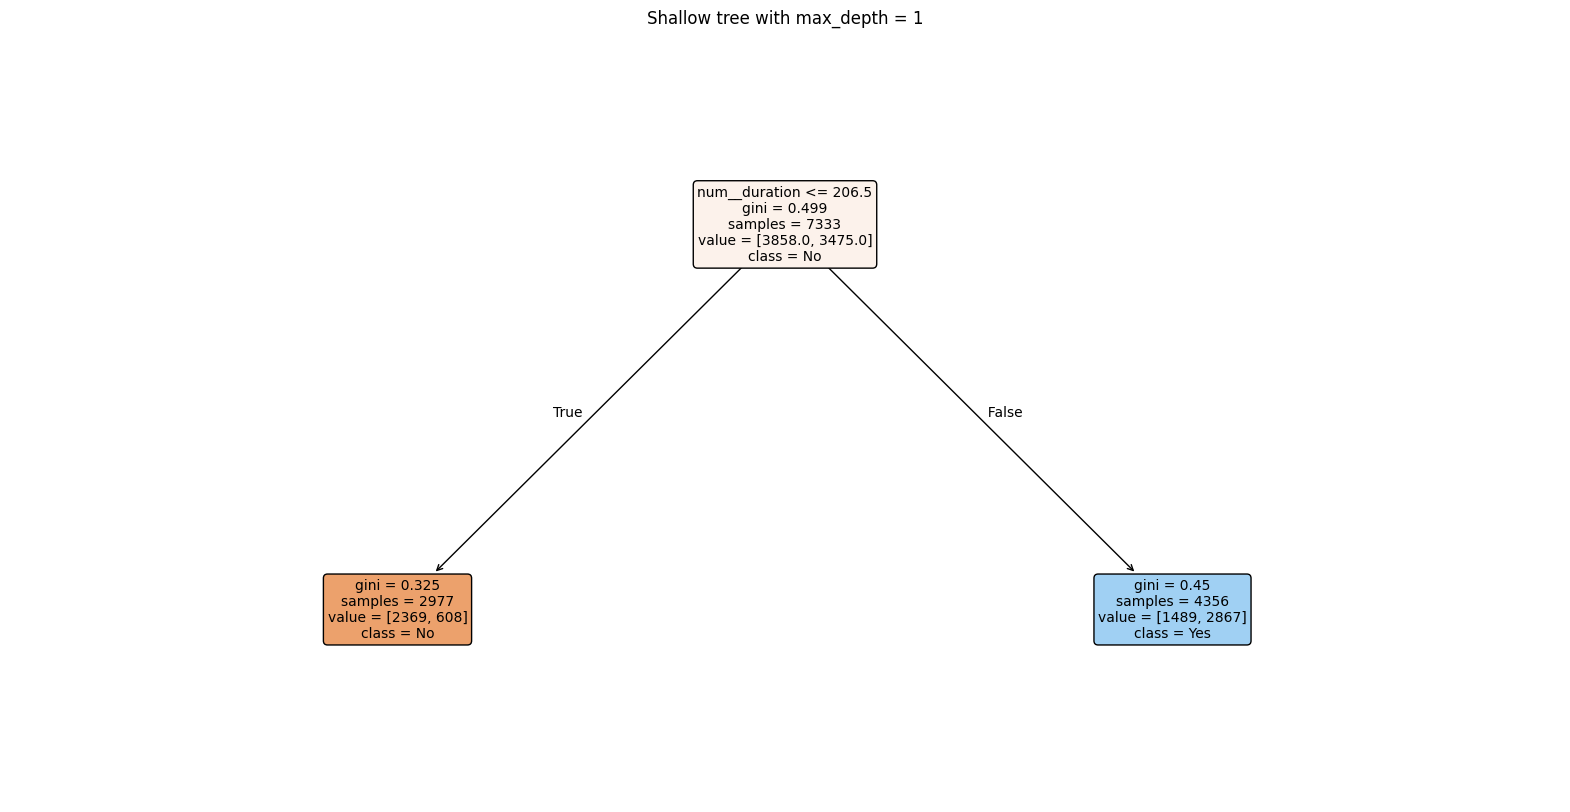

                 Variable  Importance
48          num__duration         1.0
0         cat__job_admin.         0.0
2   cat__job_entrepreneur         0.0
3      cat__job_housemaid         0.0
4     cat__job_management         0.0


In [15]:
# Understanding the problem with shallow trees:
shallow_tree1 = DecisionTreeClassifier(max_depth=1, random_state=random_seed)
pipeline_shallow = Pipeline([('preprocessor',preprocessor_tree),
                             ('tree',shallow_tree1)])
pipeline_shallow.fit(X_train, y_train)

shallow_model = pipeline_shallow.named_steps['tree']
feature_names = pipeline_shallow.named_steps['preprocessor']['column_transformer'].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(shallow_model, feature_names=feature_names, class_names=['No', 'Yes'],
          filled=True, rounded=True, fontsize=10)
plt.title("Shallow tree with max_depth = 1")
plt.show()

importance = pd.DataFrame({'Variable': feature_names,
                           'Importance': shallow_tree1.feature_importances_}
                          ).sort_values(by='Importance', ascending=False)
print(importance.head(5))

If we limit the depth of the tree to 1, we will get that the most decisive variable for predicting if a client has subscribed a term deposit will be **duration**; i.e., the duration of the last contact with the bank.

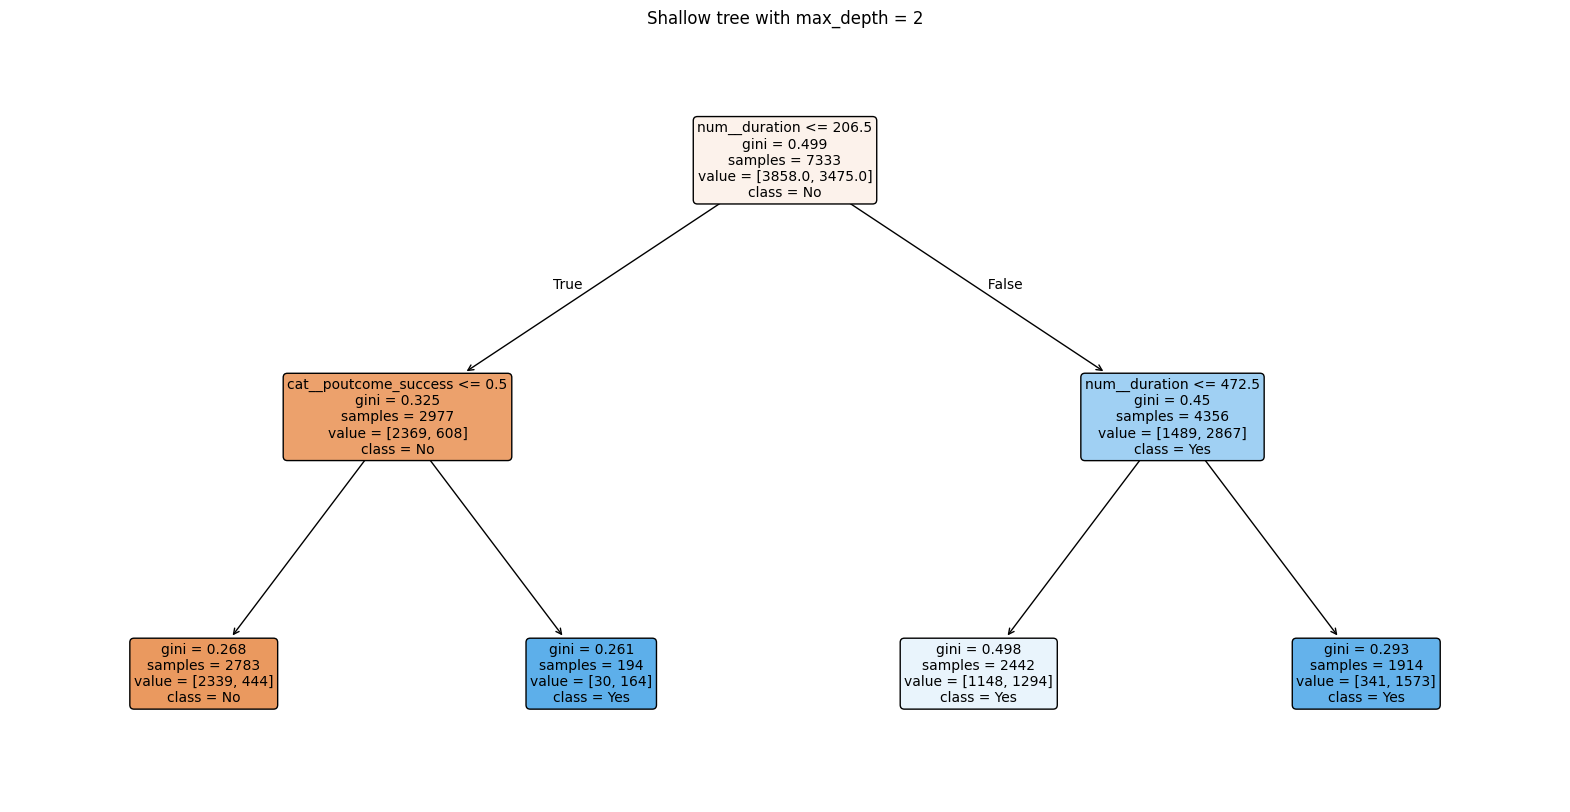

                 Variable  Importance
48          num__duration    0.842372
32  cat__poutcome_success    0.157628
2   cat__job_entrepreneur    0.000000
3      cat__job_housemaid    0.000000
0         cat__job_admin.    0.000000


In [16]:
shallow_tree2 = DecisionTreeClassifier(max_depth=2, random_state=random_seed)
pipeline_shallow = Pipeline([('preprocessor',preprocessor_tree),
                             ('tree',shallow_tree2)])
pipeline_shallow.fit(X_train, y_train)

shallow_model = pipeline_shallow.named_steps['tree']
feature_names = pipeline_shallow.named_steps['preprocessor']['column_transformer'].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(shallow_model, feature_names=feature_names, class_names=['No', 'Yes'],
          filled=True, rounded=True, fontsize=10)
plt.title("Shallow tree with max_depth = 2")
plt.show()

importance = pd.DataFrame({'Variable': feature_names,
                           'Importance': shallow_tree2.feature_importances_}
                          ).sort_values(by='Importance', ascending=False)
print(importance.head(5))


If we now allow the depth of the tree to be 2, we will get that **poutcome_success** (i.e., the outcome of the previous marketing campaign) is the second most important predictor, although **duration** is the most important by far.

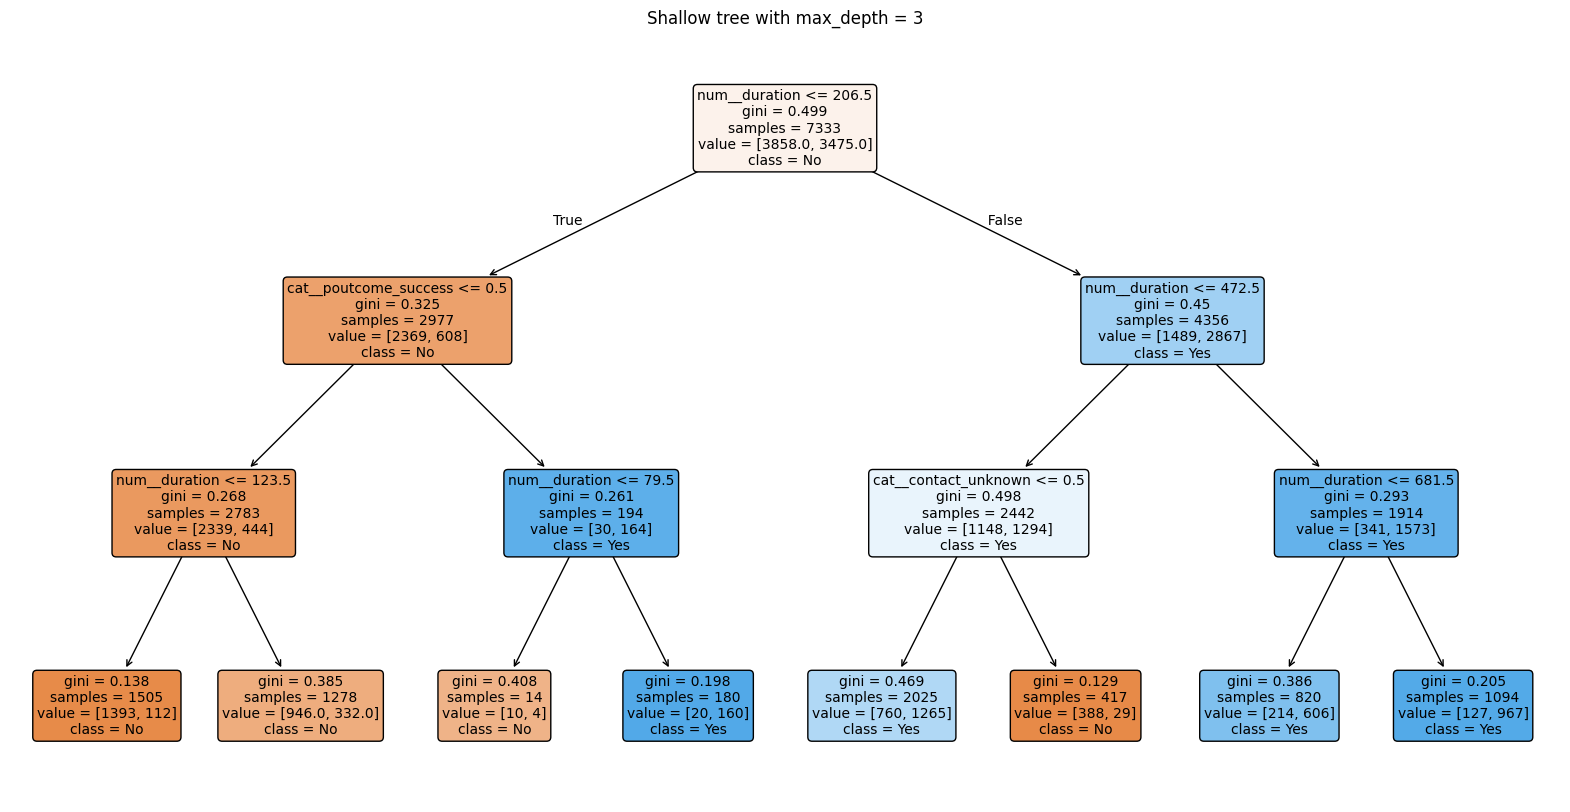

                 Variable  Importance
48          num__duration    0.720321
29   cat__contact_unknown    0.155340
32  cat__poutcome_success    0.124339
2   cat__job_entrepreneur    0.000000
0         cat__job_admin.    0.000000


In [17]:
shallow_tree3 = DecisionTreeClassifier(max_depth=3, random_state=random_seed)
pipeline_shallow = Pipeline([('preprocessor',preprocessor_tree),
                             ('tree',shallow_tree3)])
pipeline_shallow.fit(X_train, y_train)

shallow_model = pipeline_shallow.named_steps['tree']
feature_names = pipeline_shallow.named_steps['preprocessor']['column_transformer'].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(shallow_model, feature_names=feature_names, class_names=['No', 'Yes'],
          filled=True, rounded=True, fontsize=10)
plt.title("Shallow tree with max_depth = 3")
plt.show()

importance = pd.DataFrame({'Variable': feature_names,
                           'Importance': shallow_tree3.feature_importances_}
                          ).sort_values(by='Importance', ascending=False)
print(importance.head(5))

If we allow a third one, **contact** (contact communication type) gains importance and becomes the second most important variable, while **poutcome_success** falls to the third place, although they are almost as relevant. However, the most relevant by far is still **duration**.

## HYPERPARAMETER OPTIMIZATION

Now, it is time to continue with rest of the project. Up until now, we have been using the models with standard hyperparameters. Nevertheless, we can obtain more satisfying results if we apply HPO. As a first method, we will apply GridSearch, searching all the parameters one by one among a list of given values. This is not the most optimal method, but will serve us as a first approach to HPO.

We will be optimizing th next hyperparameters:

- **KNN**:
  - **n_neighbors**: Number of closest neighbors considered for each instance, typically called k as well.

  - **weight**: This is just a ponderation considered for the closest neighbors. If "uniform" is selected, then there is no ponderation, whereas if "distance" is selected, closest neighbors will have more decision power for the final prediction than further ones.
- **Decision Trees**:

  - **max_depth**: Maximum depth a tree can have.
  - **min_samples_split**: Minimum number of instances a node may have so that it can split itself a next time.

In [18]:
# Hyperparameter optimization with GridSearch:

# We first define the inner evaluation we will use for evaluating the Grid Search.
inner = KFold(n_splits =3,shuffle = True, random_state = random_seed)

## For trees:
start_tree = time.time()
# We first define the grid of hyperparameters we will be using:
tree_grid = {'classifier__max_depth': [1,2,3,4,5,6,8,9,10,12,15,20,25,30],
             'classifier__min_samples_split':[2, 5, 10, 20, 50, 100, 200, 500]}
# Now, we start the grid search and fit the results.
tree_hpo = GridSearchCV(pipeline_tree,tree_grid,scoring = 'accuracy',
                        cv = inner,n_jobs =-1,verbose=1)
tree_hpo.fit(X_train, y_train)
end_tree = time.time()
print(f"Best parameters for CART: {tree_hpo.best_params_}")
print(f"Best accuracy for CART: {tree_hpo.best_score_:.4f}")
print(f"Time taken for GridSearch in CART: {end_tree-start_tree:.4f} seconds")

## For knn:
start_knn = time.time()
# We define our grid of hyperparameters:
knn_grid = {'knn__n_neighbors':range(1,101,2),
            'knn__weights':['uniform','distance']}
# Now, we do the GridSearch and fit the results:
knn_hpo = GridSearchCV(pipeline_knn,knn_grid,scoring = 'accuracy',
                       cv = inner,n_jobs=-1,verbose=1)
knn_hpo.fit(X_train, y_train)
end_knn = time.time()
print(f"Best parameters for knn: {knn_hpo.best_params_}")
print(f"Best accuracy for knn: {knn_hpo.best_score_:.4f}")
print(f"Time taken for GridSearch in KNN: {end_knn-start_knn:.4f} seconds")

Fitting 3 folds for each of 112 candidates, totalling 336 fits
Best parameters for CART: {'classifier__max_depth': 10, 'classifier__min_samples_split': 50}
Best accuracy for CART: 0.8121
Time taken for GridSearch in CART: 68.0220 seconds
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters for knn: {'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Best accuracy for knn: 0.8118
Time taken for GridSearch in KNN: 66.4077 seconds


The next method we are going to implement is known as CASH. This method, is not only for HPO, but also for choosing the best model. This means that it will not only try to fit the best hyperparameters for a given method, but also will try to discover which is the best method out of Decision Trees and KNN. In Python, the CASH method is implemented with a function called Optuna, which will help us determine the best model and its associated hyperparameters.

In [19]:
# Hyperparamenter Optimization with Optuna:

# We fisrt create the objective function that the Optuna function will target
# in order to optimize hyperparameters.
def objective(trial):
  method = trial.suggest_categorical('method',['tree','knn'])
  if method == "tree":
    max_depth = trial.suggest_int('max_depth',2,30)
    min_samples_split = trial.suggest_int('min_samples_split',2,300)
    params = {'max_depth':max_depth, 'min_samples_split':min_samples_split}
    regr = Pipeline([('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(random_state=random_seed,**params))])
  else:
    n_neighbors = trial.suggest_int('n_neighbors',1,30)
    weights = trial.suggest_categorical('weights',['uniform','distance'])
    params = {'n_neighbors':n_neighbors,'weights':weights}
    regr = Pipeline([('preprocessor',preprocessor_knn),
     ('knn',KNeighborsClassifier(**params))])
  scores = cross_val_score(regr,X_train,y_train,scoring = 'accuracy',cv = inner)
  return scores.mean()

# We create the sampler that will be used for applying Optuna.

budget = 30
sampler = optuna.samplers.TPESampler(seed = random_seed)
study = optuna.create_study(direction = 'maximize',sampler = sampler)

start_study = time.time()

study.optimize(objective,n_trials = budget)

end_study = time.time()
time_study = end_study - start_study
print(f"Time taken for Optuna with KNN and trees: {time_study:.4f} seconds")

print(study.best_params)
print(study.best_value)



[I 2025-12-23 20:07:39,962] A new study created in memory with name: no-name-223e7d2d-b25e-4668-9885-0f04ffe25f74
[I 2025-12-23 20:07:40,961] Trial 0 finished with value: 0.8119475152760626 and parameters: {'method': 'knn', 'n_neighbors': 18, 'weights': 'distance'}. Best is trial 0 with value: 0.8119475152760626.
[I 2025-12-23 20:07:41,319] Trial 1 finished with value: 0.7796271380072449 and parameters: {'method': 'tree', 'max_depth': 22, 'min_samples_split': 3}. Best is trial 0 with value: 0.8119475152760626.
[I 2025-12-23 20:07:41,705] Trial 2 finished with value: 0.8113995628876193 and parameters: {'method': 'tree', 'max_depth': 16, 'min_samples_split': 119}. Best is trial 0 with value: 0.8119475152760626.
[I 2025-12-23 20:07:42,077] Trial 3 finished with value: 0.7996735602792254 and parameters: {'method': 'tree', 'max_depth': 15, 'min_samples_split': 18}. Best is trial 0 with value: 0.8119475152760626.
[I 2025-12-23 20:07:42,345] Trial 4 finished with value: 0.8060824221247143 and

Time taken for Optuna with KNN and trees: 12.7579 seconds
{'method': 'tree', 'max_depth': 21, 'min_samples_split': 69}
0.8146734431357849


At this stage we can draw some conclusions about HPO techniques: Optuna is a far more solid method than Grid Search. Theoretically, even though we obtained a higher accuracy with Optuna, Grid Search should obtain higher values if provided with a long enough list. Nevertheless, Optuna has an optimization algorithm that allows it to reach points close to the maximum in far less time than Grid Search. Thus, even though theoretical performance should be slightly worse for Optuna, this computational time reduction (67 seconds vs 12 seconds) makes it a more consistent method.

## HYPERPARAMETERS AND PERFORMANCE IN KNN

The next part of this assignment will focus on studying the effect the different hyperparameters may have on the KNN performance.

Up until now, we have been working with two hyperparameters for KNN: the number of neighbors and the weights. In this section, we will do a plot of two curves, one for each weight, and will be varying the number of closest neighbors in both of them. We will study how the accuracy changes for both pairs of hyperparameters.

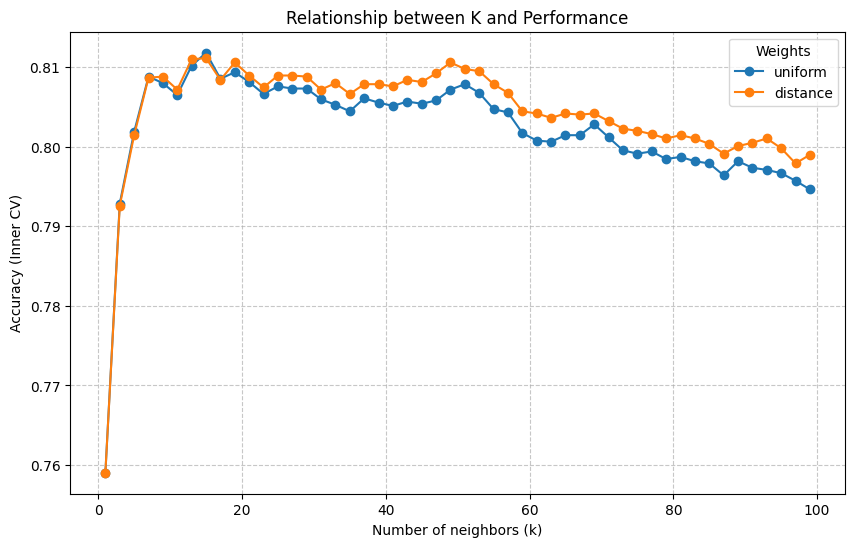

In [20]:
# Understanding HP values in KNN and performance:

results_df=pd.DataFrame(knn_hpo.cv_results_)
weights_col='param_knn__weights'
k_col='param_knn__n_neighbors'

plt.figure(figsize=(10,6))
for w in results_df[weights_col].unique():
    subset=results_df[results_df[weights_col]==w]
    plt.plot(subset[k_col],subset['mean_test_score'],marker='o',label=str(w))
plt.title('Relationship between K and Performance')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy (Inner CV)')
plt.legend(title='Weights')
plt.grid(True,linestyle='--',alpha=0.7)
plt.show()

This graphic, as we already mentioned, is composed by a total of two curves, one for the distance weight and another for the uniform weight. The distance weight tends to produce greater accuracies overall than the uniform weight. However,the maximum, which is reached for both distributions at the same point, is higher for uniform weight than for the distance one.

As for the behavior of both curves, they both reach a maximum at k = 15 approximately and then they start to decline as k increases. Although the "distance" curve is always higher than the "uniform" one, the maximum seems to happen at the "uniform" curve, which may seem an statiscial coincidence, but this will be selected as the overall best weighting method.

## Summary of the most basic methods

Up until this point, we have been working with the two most basic methods in Machine Learning: KNN and Decision Trees. When used with standard parameters, both provide accuracies close to 80%; being the one obtained with KNN slightly higher.

For trying to improve these accuracies, the Grid Search method has been implemented, for trying to find the most optimal hyperparameters for each of these methods. While Grid Search is a computationally costly technique, which drastically increases the computation times, it also allows us to moderately increase our accuracies to 81%. While these increments may not seem signficant, they prove that hyperparameters fine tuning is an effective technique that can actually cause a performance increase.

As a second way for trying to optimize hyperparameters, the Optuna function was used. This function has its own internal HPO methods that allowed us to optimize hyperparameters not only from one of the methods separately, but also to select the best method out of both KNN and Classification Trees. The overall accuracy was increased up to 81.46%, being Decision Trees with optimal hyperparameters the best out of the two methods. However, this increase in performance is not the main reason to choose this HPO method over Grid Search. The main reason is that Optuna, as it has already been mentioned, has its own HPO algorithm that helps it find the most optimal hyperparameters efficiently, while Grid Search relies on brute force; it just tries all the possible combinations and chooses the best out of all of them. Although Grid Search will always reach the maximum and Optuna is not expected to do so, it is computationally too costly and in practice, it is not useful. As a result, for future HPO processes that will be carried out throughout this assignment, Optuna will be chosen as the preferred HPO algorithm.

Finally, if we were to choose between KNN and Decision Trees, the latter provide slightly higher accuracies if their hyperparameters are correctly adjusted. Nevertheless, this difference is insignificant and does not necessarily justify the selection of one method over the other. However, Decision Trees do have an advantage, they can be implemented in some Machine Learning advanced methods and will be the key for the next part of this assignment.

# **ADVANCED METHODS**

## BAGGING TECHNIQUES


To enhance predictive performance and reduce variance, we turn to Bagging (Bootstrap Aggregating) techniques. These ensemble methods operate by training multiple independent base estimators on random subsets of the data and aggregating their predictions to form a robust consensus. We begin by implementing Random Forest, a standard bagging algorithm that constructs a multitude of decision trees and de-correlates them by considering only a random subset of features for each split.

Subsequently, we compare this baseline against Extra Trees (Extremely Randomized Trees). While sharing the same fundamental structure as Random Forest, Extra Trees introduces further randomness by selecting split thresholds completely at random rather than searching for the most optimal cut. The following code evaluates both approaches via cross-validation to determine which ensemble method yields the superior accuracy for our specific dataset.

In [21]:
# Random forest with standard parameters:

randFor = RandomForestClassifier(random_state = random_seed)

randForPipeline = Pipeline([('preprocessor',preprocessor_tree),
 ('classifier',randFor)])
sta_for = time.time()
forest_scores = cross_val_score(randForPipeline,X_train,y_train,
                              scoring = "accuracy",cv =kf)
end_for = time.time()
time_for = end_for - sta_for

print(f"Accuracy of the RF with standard parameters:{forest_scores.mean():.4f} (+/- {forest_scores.std():.4f})")
print(f"Time taken for the random forest method: {time_for:.4f} seconds")


# We compare it to what we could do if we used Extra Trees instead:

extra_trees = ExtraTreesClassifier(random_state=random_seed)
et_pipeline = Pipeline([('preprocessor', preprocessor_tree),
 ('classifier', extra_trees)])
sta_extra = time.time()
et_scores = cross_val_score(et_pipeline, X_train, y_train,
                            scoring="accuracy", cv=kf)
end_extra = time.time()
time_extra = end_extra-sta_extra
print(f"Accuracy of Extra Trees with standard parameters: {et_scores.mean():.4f} (+/- {et_scores.std():.4f})")
print(f"Time taken for the extra trees method: {time_extra:.4f} seconds")

# And so, our choice of the Random Forest method seems logical.



Accuracy of the RF with standard parameters:0.8512 (+/- 0.0052)
Time taken for the random forest method: 2.9198 seconds
Accuracy of Extra Trees with standard parameters: 0.8215 (+/- 0.0066)
Time taken for the extra trees method: 3.5911 seconds


The results indicate that the Random Forest model outperforms the Extra Trees classifier, achieving a higher mean accuracy of 85.12% compared to 82.15%. Although Extra Trees offers a marginal speed advantage, the difference in computational time is negligible (less than 0.05 seconds). Consequently, the significant gain in predictive performance justifies selecting Random Forest as the primary model for this task.

To maximize the predictive performance of the Random Forest model, we implement an automated hyperparameter search process using the Optuna library. An objective function is defined to train and evaluate the model via cross-validation, aiming to maximize accuracy within a search space configured by the following key parameters:

- **max_depth**: Controls the maximum depth of each tree, limiting complexity to prevent overfitting.

- **min_samples_split**: Defines the minimum number of samples required to allow an internal node to split.

- **n_estimators**: Determines the total number of individual decision trees that will make up the forest.

- **max_features**: Specifies the number of variables or features considered when searching for the best split at each node.

The study is then executed using a TPE (Tree-structured Parzen Estimator) sampling strategy with a fixed iteration budget:

In [22]:
# Hyperparameter optimization of the Random Forest with Optuna:

def objective(trial):
  max_depth = trial.suggest_int('max_depth',2,30)
  min_samples_split = trial.suggest_int('min_samples_split',2,300)
  n_estimators = trial.suggest_int('n_estimators',50,500)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2',None])
  params = {'max_depth':max_depth, 'min_samples_split':min_samples_split,
            'n_estimators':n_estimators,'max_features':max_features,'n_jobs':-1}
  regr = Pipeline([('preprocessor', preprocessor_tree),
   ('classifier', RandomForestClassifier(random_state=random_seed,**params))])
  scores = cross_val_score(regr,X_train,y_train,scoring = 'accuracy',
                           cv = inner,n_jobs=1)
  return scores.mean()

budget = 30
sta_study_for = time.time()
sampler = optuna.samplers.TPESampler(seed = random_seed)
studyRF = optuna.create_study(direction = 'maximize',sampler = sampler)
studyRF.optimize(objective,n_trials = budget)
end_study_for = time.time()
time_study_for = end_study_for - sta_study_for
print(studyRF.best_params)
print(studyRF.best_value)
print(f"Time taken for HPO with Optuna for Random Forest: {time_study_for:.4f} seconds" )


[I 2025-12-23 20:07:59,465] A new study created in memory with name: no-name-c5846865-d223-4ec5-bb5a-19ecffe6749e
[I 2025-12-23 20:08:15,852] Trial 0 finished with value: 0.827356061392088 and parameters: {'max_depth': 11, 'min_samples_split': 210, 'n_estimators': 315, 'max_features': None}. Best is trial 0 with value: 0.827356061392088.
[I 2025-12-23 20:08:16,661] Trial 1 finished with value: 0.743760773012829 and parameters: {'max_depth': 2, 'min_samples_split': 216, 'n_estimators': 52, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.827356061392088.
[I 2025-12-23 20:08:29,132] Trial 2 finished with value: 0.8247649600540868 and parameters: {'max_depth': 13, 'min_samples_split': 246, 'n_estimators': 242, 'max_features': None}. Best is trial 0 with value: 0.827356061392088.
[I 2025-12-23 20:08:36,721] Trial 3 finished with value: 0.8347214831028955 and parameters: {'max_depth': 15, 'min_samples_split': 118, 'n_estimators': 496, 'max_features': 'log2'}. Best is trial 3 with valu

{'max_depth': 27, 'min_samples_split': 5, 'n_estimators': 496, 'max_features': 'log2'}
0.8535396285102589
Time taken for HPO with Optuna for Random Forest: 265.6320 seconds


The hyperparameter optimization process was completed in 262.73 seconds (approximately 4.4 minutes), efficiently exploring 30 different model configurations. The search successfully identified a peak performance in Trial 10, achieving an accuracy of 85.35%. This result highlights the critical value of tuning, as it significantly outperforms the suboptimal configurations found earlier in the search (such as Trial 1, which yielded only ~74%). The optimal set of parameters—specifically a high max_depth of 27, a low min_samples_split of 5, and a high count of n_estimators (496)—suggests that a deeper, more granular forest structure was necessary to maximize the model's predictive power compared to shallower or less complex default settings.

The increase in accuracy with respect to the method with default parameters (85.12%) is not significant and does not justify the use of HPO, bearing in mind that the computation time dramatically increases.

## GRADIENT BOOSTING TECHNIQUES

Having explored bagging with Random Forest, we now advance to Gradient Boosting techniques. Unlike bagging methods that build independent trees in parallel, gradient boosting constructs an ensemble sequentially, where each new tree is explicitly trained to correct the residual errors of the previous ones, effectively turning weak learners into a strong predictor. For this stage, we utilize XGBoost (Extreme Gradient Boosting), a highly efficient and scalable implementation of this algorithm. XGBoost is renowned for its speed and performance, distinguishing itself through features like parallel processing, tree pruning, and built-in regularization to mitigate overfitting. The following code establishes a baseline performance using the standard, default parameters:

In [23]:
# Gradient boosting method with standard parameters:

xgb = XGBClassifier(random_state=random_seed)
xgbPipeline = Pipeline([('preprocessor', preprocessor_tree), ('classifier', xgb)])
sta_xgb = time.time()
xgbScores = cross_val_score(xgbPipeline, X_train, y_train, scoring='accuracy', cv=kf)
end_xgb = time.time()
time_xgb = end_xgb - sta_xgb
print(f"Accuracy of XGBoost with standard parameters: {xgbScores.mean():.4f} (+/- {xgbScores.std():.4f})")
print(f"Computation time for XGBoost with standard parameters {time_xgb:.4f} seconds")

Accuracy of XGBoost with standard parameters: 0.8567 (+/- 0.0051)
Computation time for XGBoost with standard parameters 0.7687 seconds


The baseline XGBoost model demonstrated remarkable efficiency, achieving an accuracy of 85.67% in just 0.98 seconds. Notably, this out-of-the-box performance already slightly surpasses the optimized Random Forest (85.35%), underscoring the power of gradient boosting for this specific dataset.

However, given the nature of our data, we turn to CatBoost (Categorical Boosting) as a potentially superior alternative. While XGBoost is highly effective, it typically requires numerical input, forcing the use of techniques like One-Hot Encoding for categorical features. In datasets with many categorical variables—like the one used in this work—this can lead to sparse matrices and reduced performance.

CatBoost is specifically designed to solve this. We choose it over XGBoost here because it handles categorical features natively using a method called ordered target statistics. This avoids the dimensionality explosion of encoding and reduces the risk of overfitting, often making it the state-of-the-art solution for tabular data rich in categorical information.

In [24]:

# --- Preprocessing ---

# We create this to_string function to ensure CatBoost receives text, and not NA/None.
def to_string_func(X):
    return X.astype(str)
# We create a new preprocessor for CatBoost, since it odes not need OneHotEncoding,
# CatBoost already does this with some internal methods.
cat_transformer_catboost = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('to_string', FunctionTransformer(to_string_func, validate=False))
])

num_transformer_catboost = SimpleImputer(strategy='median')

preprocessor_catboost = Pipeline([
    ('pdays_transform', PdaysTransformer()),
    ('column_transformer', ColumnTransformer(
        transformers=[
            ('cat', cat_transformer_catboost, cat_cols),
            ('num', num_transformer_catboost, num_cols)
        ]
    ))
])

# Once the preprocessing is done, we can apply the CatBoost method.
catb = CatBoostClassifier(random_state=random_seed, verbose=0, thread_count=1,
                          cat_features=list(range(len(cat_cols))))

catPipeline = Pipeline([('preprocessor', preprocessor_catboost), ('classifier', catb)])
sta_cat = time.time()
catScores = cross_val_score(catPipeline, X_train, y_train, scoring='accuracy',
                            cv=kf, n_jobs=-1)
end_cat = time.time()
time_cat = end_cat - sta_cat
print(f"Accuracy of CatBoost with standard parameters: {catScores.mean():.4f} (+/- {catScores.std():.4f})")
print(f"Computation time for CatBoost with standard parameters: {time_cat:.4f} seconds")

Accuracy of CatBoost with standard parameters: 0.8619 (+/- 0.0065)
Computation time for CatBoost with standard parameters: 38.6293 seconds


The implementation of CatBoost yielded an accuracy of 86.19%, representing a clear improvement over the XGBoost baseline (85.67%). This confirms that handling categorical variables natively provides a tangible predictive edge for this specific dataset. However, this gain presents a significant trade-off in efficiency: the computation time rose to 51.82 seconds, a sharp contrast to the sub-second execution (0.98s) observed with XGBoost.

Despite the substantial increase in training time, the primary objective of this study is to maximize predictive power. Since the runtime remains within feasible limits for our resources, we prioritize the superior accuracy and will therefore proceed with CatBoost as the selected model for the remainder of this work.

To further refine the predictive capabilities of the CatBoost model, we proceed with a hyperparameter optimization phase using Optuna. As with the Random Forest, we define an objective function that maximizes accuracy through cross-validation, but this time navigating a search space specific to gradient boosting dynamics. The key hyperparameters being tuned include:

- **iterations**: The maximum number of trees to be constructed in the ensemble.

- **learning_rate**: Controls the step size at each iteration, determining how strongly each tree corrects the errors of the previous ones.

- **depth**: The depth of the trees, which dictates the level of feature interaction the model can capture.

- **l2_leaf_reg**: Coefficient for the L2 regularization term, crucial for controlling model complexity and preventing overfitting.

- **random_strength**: Adds randomness to the scoring of splits during tree construction, helping to avoid local optima and improve generalization.

The optimization is executed with a budget of 30 trials using the TPE sampler:

In [25]:
# Doing HPO with CatBoost:

def objective(trial):
    iterations = trial.suggest_int('iterations', 500, 2000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 10)
    random_strength = trial.suggest_float('random_strength', 1e-9, 10, log=True)

    params = {
        'iterations': iterations,
        'learning_rate': learning_rate,
        'depth': depth,
        'l2_leaf_reg': l2_leaf_reg,
        'random_strength': random_strength,
        'verbose': 0,
        'thread_count': -1,
        'cat_features': list(range(len(cat_cols)))
    }

    regr = Pipeline([
        ('preprocessor', preprocessor_catboost),
        ('classifier', CatBoostClassifier(random_state=random_seed, **params))
    ])

    scores = cross_val_score(regr, X_train, y_train, scoring='accuracy',
                             cv=inner, n_jobs=1)

    return scores.mean()
budget = 30
sta_study_cat = time.time()
sampler = optuna.samplers.TPESampler(seed=random_seed)
studyCat = optuna.create_study(direction='maximize', sampler=sampler)
studyCat.optimize(objective, n_trials=budget)
end_study_cat = time.time()
time_study_cat = end_study_cat - sta_study_cat

print(studyCat.best_params)
print(studyCat.best_value)
print(f"Computation time for HPO with CatBoost: {time_study_cat:.4f} seconds")

[I 2025-12-23 20:13:04,532] A new study created in memory with name: no-name-4318efd1-a143-4d27-898a-22a2b72c7c0a
[I 2025-12-23 20:14:16,806] Trial 0 finished with value: 0.8610393189168807 and parameters: {'iterations': 1004, 'learning_rate': 0.10683780412245561, 'depth': 8, 'l2_leaf_reg': 4, 'random_strength': 0.00018955472197822792}. Best is trial 0 with value: 0.8610393189168807.
[I 2025-12-23 20:17:00,773] Trial 1 finished with value: 0.8637666413413704 and parameters: {'iterations': 1533, 'learning_rate': 0.010280525828700392, 'depth': 9, 'l2_leaf_reg': 1, 'random_strength': 0.005380542113329456}. Best is trial 1 with value: 0.8637666413413704.
[I 2025-12-23 20:17:54,326] Trial 2 finished with value: 0.862266368564502 and parameters: {'iterations': 1240, 'learning_rate': 0.05402348926485928, 'depth': 6, 'l2_leaf_reg': 9, 'random_strength': 1.821607455117068e-05}. Best is trial 1 with value: 0.8637666413413704.
[I 2025-12-23 20:19:21,667] Trial 3 finished with value: 0.86349364134

{'iterations': 1331, 'learning_rate': 0.04977498949365831, 'depth': 7, 'l2_leaf_reg': 4, 'random_strength': 2.2335078373510777e-09}
0.8644485835126744
Computation time for HPO with CatBoost: 3763.2265 seconds


The hyperparameter optimization for CatBoost proved to be a computationally intensive endeavor, requiring a total of 3,879.53 seconds (approximately 65 minutes) to complete. This massive increase in execution time contrasts sharply with the sub-minute performance of the default model. However, this investment yielded a refined accuracy of 86.44% (found in Trial 9), improving upon the baseline of 86.19%.

The winning configuration utilized 1,331 iterations and a depth of 7, effectively fine-tuning the model's complexity to squeeze out maximum predictive power. While the marginal gain in accuracy might seem modest relative to the hour-long runtime, it represents the performance ceiling for this dataset. Therefore, we accept this trade-off to ensure the highest possible precision for our final model, which we will now subject to interpretability analysis.

As a final due diligence step before committing fully to CatBoost, we will perform hyperparameter optimization on XGBoost. The objective here is twofold: to see if a tuned XGBoost model can rival the accuracy of CatBoost and to confirm its expected advantage in computational efficiency. In this search space, we introduce two new hyperparameters specific to gradient boosting control:

- **min_child_weight**: Defines the minimum sum of instance weights (hessian) needed in a child node. It is similar to min_samples_leaf in Random Forest but considers weights, effectively controlling overfitting by preventing specific splits.

- **subsample**: The ratio of training instances used to grow trees. Setting this below 1.0 means the algorithm uses a random fraction of the data for each tree, a technique known as Stochastic Gradient Boosting.

In [26]:
# Doing HPO with XGBoost:

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'n_jobs': 1
    }

    regr = Pipeline([
        ('preprocessor', preprocessor_tree),
        ('classifier', XGBClassifier(random_state=random_seed, **params))
    ])

    scores = cross_val_score(regr, X_train, y_train, scoring='accuracy',
                             cv=inner, n_jobs=-1)

    return scores.mean()

budget = 30
start_study_xgb = time.time()
sampler = optuna.samplers.TPESampler(seed=random_seed)
studyXGB = optuna.create_study(direction='maximize', sampler=sampler)
studyXGB.optimize(objective, n_trials=budget)
end_study_xgb = time.time()
time_study_xgb  = end_study_xgb - start_study_xgb

print(studyXGB.best_params)
print(studyXGB.best_value)
print(f"Computation time for HPO with XGBoost: {time_study_xgb:.4f} seconds")

[I 2025-12-23 21:15:47,807] A new study created in memory with name: no-name-454713f8-e7c6-44cd-acf3-1cb4990f8164
[I 2025-12-23 21:15:53,109] Trial 0 finished with value: 0.853539405379896 and parameters: {'n_estimators': 402, 'learning_rate': 0.10683780412245561, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.763886730378124}. Best is trial 0 with value: 0.853539405379896.
[I 2025-12-23 21:15:58,614] Trial 1 finished with value: 0.8609029862652106 and parameters: {'n_estimators': 720, 'learning_rate': 0.010280525828700392, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8365413017476921}. Best is trial 1 with value: 0.8609029862652106.
[I 2025-12-23 21:16:01,883] Trial 2 finished with value: 0.8566757257593963 and parameters: {'n_estimators': 544, 'learning_rate': 0.05402348926485928, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7130227397502922}. Best is trial 1 with value: 0.8609029862652106.
[I 2025-12-23 21:16:04,824] Trial 3 finished with value: 0.8569481121

{'n_estimators': 720, 'learning_rate': 0.010280525828700392, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8365413017476921}
0.8609029862652106
Computation time for HPO with XGBoost: 125.6688 seconds


The hyperparameter optimization for XGBoost was completed remarkably fast, finishing in 132.38 seconds (just over 2 minutes). The search identified Trial 1 as the best configuration, achieving an accuracy of 86.09%. The optimal parameters included a high number of estimators (720) combined with a very low learning rate (~0.01) and a relatively deep tree (max_depth 8).

While this result is an improvement over the standard XGBoost (85.67%) and the optimized Random Forest (85.35%), it importantly falls short of the performance achieved by CatBoost. Even the standard (un-tuned) CatBoost model slightly outperformed the optimized XGBoost (86.19% vs. 86.09%), confirming that for this specific dataset—likely due to the categorical features—CatBoost has a distinct structural advantage.

### Conclusions for the advanced methods

To make a data-driven decision, let's look at the final leaderboard summarizing our experiments:

| Model | Configuration | Accuracy | Computation Time |
| :--- | :--- | :--- | :--- |
| **Random Forest** | Standard | ~0.82 | *Fast* |
| **Random Forest** | Optimized (Optuna) | 85.35% | 262.73 s |
| **XGBoost** | Standard | 85.67% | **0.98 s** (Fastest) |
| **XGBoost** | Optimized (Optuna) | 86.09% | 132.38 s |
| **CatBoost** | Standard | 86.19% | 51.82 s |
| **CatBoost** | **Optimized (Optuna)** | **86.44%** | 3879.53 s |

Although XGBoost proved to be the most computationally efficient algorithm by a wide margin, our primary goal is predictive excellence. CatBoost is the clear winner in terms of accuracy, achieving the highest score of 86.44%.

The massive difference in optimization time (65 minutes for CatBoost vs. 2 minutes for XGBoost) highlights a significant cost. However, since the model training is a one-time "sunk cost" and we have already secured the best model weights, we will prioritize the superior precision.

## **RESULTS AND FINAL MODEL**

In this section, the inner evaluation results of all tested machine learning models are summarized and compared. The code below creates a table with the mean accuracy of each model obtained during cross-validation, rounds the values for clarity, and sorts them in descending order to highlight the
best-performing models. This table will be used to select the model for outer evaluation on the test set.


In [27]:
results_inner = pd.DataFrame({
    "Model": [
        "Dummy", "Decision Tree (CART)", "KNN",
        "Random Forest", "Extra Trees", "XGBoost", "CatBoost",
        "Tree Grid Search", "KNN Grid Search", "KNN+Tree Optuna",
        "Random Forest Optuna", "XGBoost Optuna", "CatBoost Optuna"
        ],
    "Inner mean accuracy": [
        dummy_scores.mean(),       #Mean accuracy of the DummyClassifier (baseline model)
        tree_scores.mean(),        #Mean accuracy of the Decision Tree with default hyperparameters
        knn_scores.mean(),         #Mean accuracy of KNN with default hyperparameters
        forest_scores.mean(),      #Mean accuracy of Random Forest with default hyperparameters
        et_scores.mean(),          #Mean accuracy of Extra Trees with default hyperparameters
        xgbScores.mean(),          #Mean accuracy of XGBoost with default hyperparameters
        catScores.mean(),          #Mean accuracy of CatBoost with default hyperparameters
        tree_hpo.best_score_,      #Best accuracy obtained from hyperparameter optimization of the Decision Tree
        knn_hpo.best_score_,       #Best accuracy obtained from hyperparameter optimization of KNN
        study.best_value,          #Best accuracy from combined KNN + Tree Optuna study
        studyRF.best_value,        #Best accuracy from Random Forest Optuna hyperparameter search
        studyXGB.best_value,       #Best accuracy from XGBoost Optuna hyperparameter search
        studyCat.best_value        #Best accuracy from CatBoost Optuna hyperparameter search
    ]
})

#Round the accuracy values to 4 decimal
results_inner["Inner mean accuracy"] = results_inner["Inner mean accuracy"].round(4)

# Sort the DataFrame by inner mean accuracy in descending order to highlight the top models
results_inner = results_inner.sort_values(by="Inner mean accuracy", ascending=False).reset_index(drop=True)

results_inner

,Model,Inner mean accuracy
0,CatBoost Optuna,0.8644
1,CatBoost,0.8619
2,XGBoost Optuna,0.8609
3,XGBoost,0.8567
4,Random Forest Optuna,0.8535
5,Random Forest,0.8512
6,Extra Trees,0.8215
7,KNN+Tree Optuna,0.8147
8,Tree Grid Search,0.8121
9,KNN Grid Search,0.8118


In [28]:
#Select the best model according to inner cross-validation
best_model_name = results_inner.iloc[0]["Model"]
print(f"Best model according to inner CV: {best_model_name}")

#Inner mean accuracy of the best model
print(f"\nReasoning: {best_model_name} has the highest 'Inner mean accuracy' = "
      f"{results_inner.iloc[0]['Inner mean accuracy']:.4f}")

Best model according to inner CV: CatBoost Optuna

Reasoning: CatBoost Optuna has the highest 'Inner mean accuracy' = 0.8644


The best model according to inner cross-validation is **CatBoost with Optuna hyperparameter optimization**.  
Its inner mean accuracy is very similar to CatBoost with default parameters, and in some trial runs the results have been almost the same, showing that the default hyperparameters already perform very well.  

Despite the much longer training time of the Optuna-optimized version, it is preferred because it provides greater robustness by systematically exploring the hyperparameter space. It could also offer better performance or stability on similar datasets or under slightly different conditions.  

As mentioned before, Optuna was used to optimize the key CatBoost hyperparameters: `iterations` (number of boosting rounds), `learning_rate` (step size for each iteration), `depth` (maximum tree depth), and `l2_leaf_reg` (L2 regularization on leaf weights to reduce overfitting).  

The best model is implemented as a pipeline that combines the preprocessing steps with the CatBoost classifier, which uses the hyperparameters found by Optuna and keeps the random seed fixed for reproducibility. Categorical features are properly specified, and `verbose=0` is set to suppress the training output, keeping the notebook clean. This pipeline, stored in the variable `best_model`, will be used for outer evaluation on the test set and for making predictions on future datasets, and also for storing the model.



In [29]:
#Pipeline of the best model
best_model = Pipeline([
    ('preprocessor', preprocessor_catboost),
    ('classifier', CatBoostClassifier(
        random_state=random_seed,
        verbose=0,
        thread_count=1,
        iterations=studyCat.best_params['iterations'],
        learning_rate=studyCat.best_params['learning_rate'],
        depth=studyCat.best_params['depth'],
        l2_leaf_reg=studyCat.best_params['l2_leaf_reg'],
        cat_features=list(range(len(cat_cols)))
    ))
])

In this point, the final CatBoost model is trained on the training set and evaluated on the test set to estimate its expected performance on new data (outer evaluation). The accuracy is the proportion of correct predictions on this test set and provides a point estimate of model performance.  

The 95% confidence interval is calculated using the Wilson method, which estimates the range where the true accuracy would likely fall if the model were applied to the entire population.

The point estimate of accuracy does not necessarily coincide with the midpoint of the Wilson interval. This is because the Wilson method adjusts the interval to improve coverage, especially or moderate-sized datasets and proportions near 0 or 1. Therefore, the interval provides a statistically more reliable measure of uncertainty around the observed accuracy.


In [30]:
#Train the final model on the training set
best_model.fit(X_train, y_train)

#Predict the classes on the test set: outer evaluation
y_test_pred = best_model.predict(X_test)

#Compute the accuracy on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)

#Number of correct predictions
n_test = len(y_test)
successes = n_test * accuracy_test

#Compute the 95% confidence interval for accuracy using the Wilson method
ci_low, ci_up = proportion_confint(count=successes, nobs=n_test, alpha=0.05, method='wilson')

#Display the results
print(f"Outer evaluation accuracy: {accuracy_test:.4f}")
print(f"95% confidence interval (Wilson): [{ci_low:.4f}, {ci_up:.4f}]")


Outer evaluation accuracy: 0.8634
95% confidence interval (Wilson): [0.8519, 0.8741]


The competition dataset is loaded and the final CatBoost pipeline, stored in `best_model`, is now trained on all available data to make full use of the information for final predictions.  

Predictions are generated for the competition dataset, and both the trained model and the predictions are saved for future use. The model is saved using `joblib.dump`, a method suggested after consulting AI tools to ensure proper serialization of scikit-learn and pipeline objects. The predictions are saved as a CSV file, suitable for submission or further analysis.


In [31]:
#Load the competition dataset
competition = pd.read_pickle("bank_competition.pkl")

#Train the final pipeline on the full dataset (training + test)
best_model.fit(X, y)

#Prediction on the competition dataset
competition_predictions = best_model.predict(competition)

#Save the trained model
joblib.dump(best_model, "bank_competition_final_model.pkl")

#Save the predictions as a CSV file
pd.DataFrame({'prediction': competition_predictions}).to_csv(
    "competition_predictions.csv", index=False
)

print("Final trained model saved as 'bank_competition_final_model.pkl'.")
print("Competition predictions saved as 'competition_predictions.csv'.")


Final trained model saved as 'bank_competition_final_model.pkl'.
Competition predictions saved as 'competition_predictions.csv'.


## **PROBABILITY CALIBRATION**

CatBoost with Optuna hyperparameter optimization is also selected as the best model capable of predicting probabilities. This model can provide probability estimates because CatBoost is a gradient boosting method for classification,
which naturally outputs class probabilities using the logistic transformation of the ensemble's raw predictions. This makes it suitable for tasks where not only the predicted class, but also the estimated likelihood of each
outcome, is important.  

In this section, the predicted probabilities of the positive class (`yes`) on the test set are analyzed to assess whether they are well-calibrated. Calibration curves are plotted to visualize how closely the predicted
probabilities match the actual fraction of positive outcomes. These plots were generated with the help of AI tools to ensure a clear and correct visualization.  

Additionally, the Brier score is calculated as a numerical measure of probability accuracy before any calibration is applied. This allows a quantitative assessment of how well the predicted probabilities reflect
the observed outcomes.


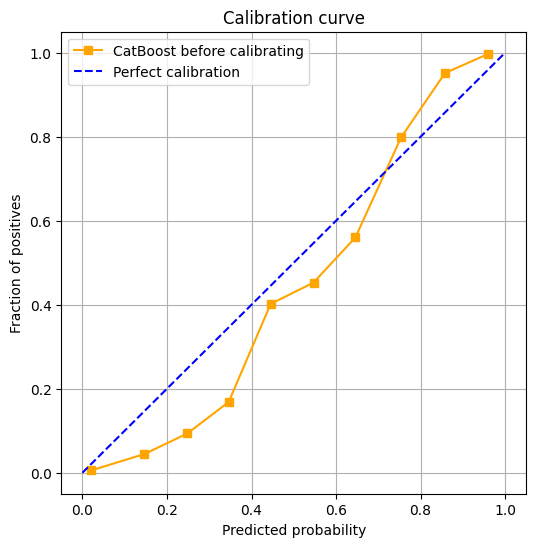

Brier score before calibration: 0.0503


In [32]:
#Predict probabilities of the positive class (yes) on the test set
y_prob_test = best_model.predict_proba(X_test)[:, 1]

#Compute calibration curve: fraction of positives vs. mean predicted probability
#Each bin contains a number of samples with similar predicted probabilities
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob_test, n_bins=10)

#Visualization
plt.figure(figsize=(6,6))

#Plot the current model's calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, "s-", color='orange', label="CatBoost before calibrating")

#Plot the perfectly calibrated line
plt.plot([0,1],[0,1], "--", color='blue', label="Perfect calibration")

plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve")
plt.legend()
plt.grid(True)
plt.show()

#Compute the Brier score before calibration
brier_before = brier_score_loss(y_test, y_prob_test)
print(f"Brier score before calibration: {brier_before:.4f}")


The CatBoost model is now calibrated using isotonic regression through scikit-learn's `CalibratedClassifierCV`, using once again 3-fold cross-validation (sigmoid method has been tried as well). Calibration adjusts the predicted probabilities
so that they better reflect the true likelihood of the positive class, without changing the predicted labels themselves.  

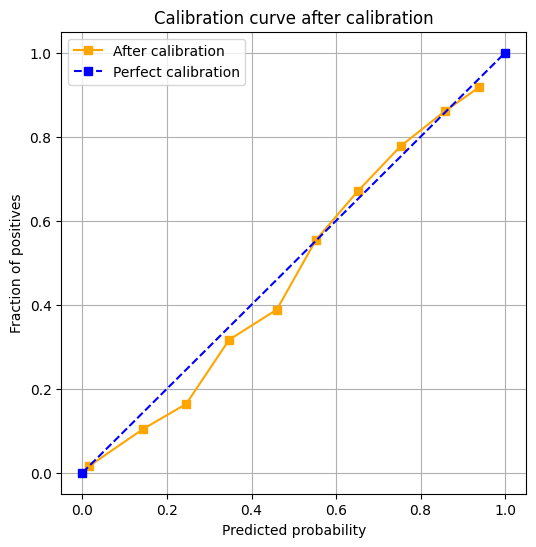

Brier score after calibration:  0.1024


In [33]:
#Wrap the trained model in a calibration wrapper using isotonic regression and 3-fold CV
calibrator = CalibratedClassifierCV(best_model, method='isotonic', cv=kf)
calibrator.fit(X_train, y_train)

#Predict calibrated probabilities on the test set
y_prob_calibrated = calibrator.predict_proba(X_test)[:, 1]

#Compute calibration curve after calibration
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

#Plot calibration curve after calibration
plt.figure(figsize=(6,6))
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", color="orange", label="After calibration")
plt.plot([0,1],[0,1], "s--", color="blue", label="Perfect calibration")  # Reference line
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve after calibration")
plt.legend()
plt.grid(True)
plt.show()

#Compute Brier score after calibration
brier_after = brier_score_loss(y_test, y_prob_calibrated)
print(f"Brier score after calibration:  {brier_after:.4f}")


After calibration, although the Brier score increase slightly after calibration, the raw classification accuracy should remain unchanged. This indicates that while the model's predicted probabilities are now more
honest and interpretable, its ability to correctly classify instances has not been affected.

The calibration curve visually confirms a closer fit to the ideal diagonal line especially on lower probability values, demonstrating improved reliability for probability-based decision-making.

Next, the classification accuracy before and after calibration is compared to assess any changes in the model's predictive performance. This allows checking whether the calibration step has impacted the model's ability to correctly classify instances.


In [34]:
#Accuracy on the test set before calibration
print(f"Accuracy before calibration: {accuracy_test:.4f}")

#Accuracy after calibration on the test set
acc_after = accuracy_score(y_test, calibrator.predict(X_test))
print(f"Accuracy after calibration:  {acc_after:.4f}")

Accuracy before calibration: 0.8634
Accuracy after calibration:  0.8645


The accuracy after calibration is slightly higher than before. This improvement is due to minor adjustments in predicted probabilities near the 0.5 threshold,
where the calibration step can shift some borderline predictions to the correct class.  

Overall, the calibration has refined the probability estimates without negatively affecting classification performance.

The final calibrated CatBoost model is used to predict the probability of subscribing to the product for each client in the competition dataset. These predicted probabilities are then saved to a CSV
file for future analysis or submission, ensuring that the probability estimates reflect the calibrated outputs of the model.



In [35]:
# Train calibrated model on the full dataset for final predictions
calibrator.fit(X, y)

competition_probs = calibrator.predict_proba(competition)[:, 1]

#Save calibrated predictions
pd.DataFrame({'prediction_prob': competition_probs}).to_csv(
    "competition_predictions_calibrated.csv", index=False)

## **OPEN CHOICE TASK: INTERPRETING CATBOOST PREDICTIONS WITH SHAP**

For the final Open Choice Task of this project, we decided to focus on Model Interpretability. While ensemble methods like CatBoost offer superior predictive performance, they are often criticized as "black boxes" due to their complexity. To bridge the gap between accuracy and transparency, we implement SHAP (SHapley Additive exPlanations). This game-theoretic approach allows us to quantify the contribution of each feature to the model's output, providing both a global view of feature importance and a detailed local explanation for individual predictions, ensuring the model's decisions are trustworthy and understandable.

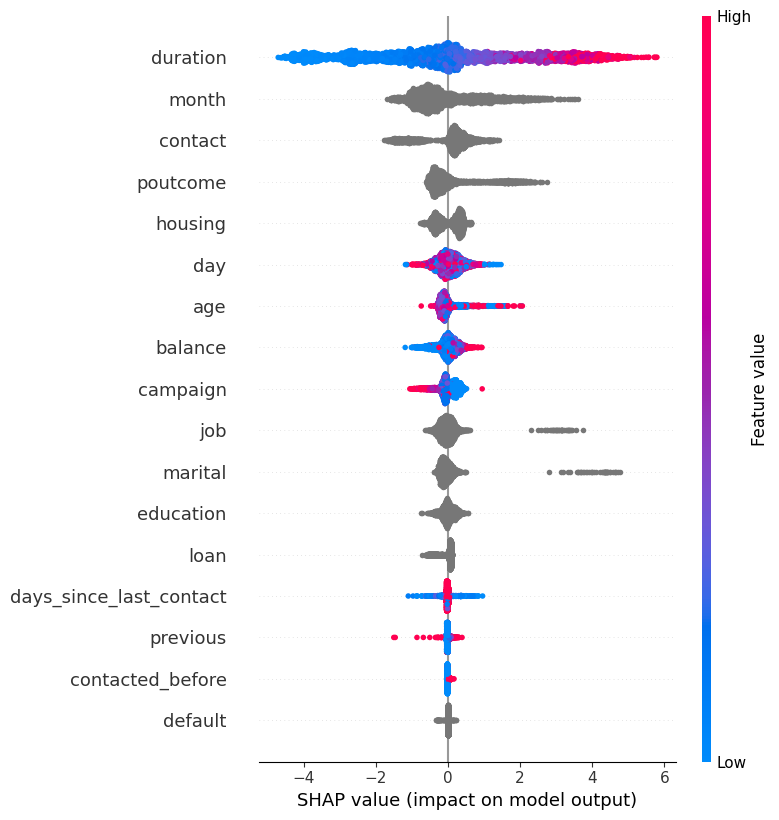

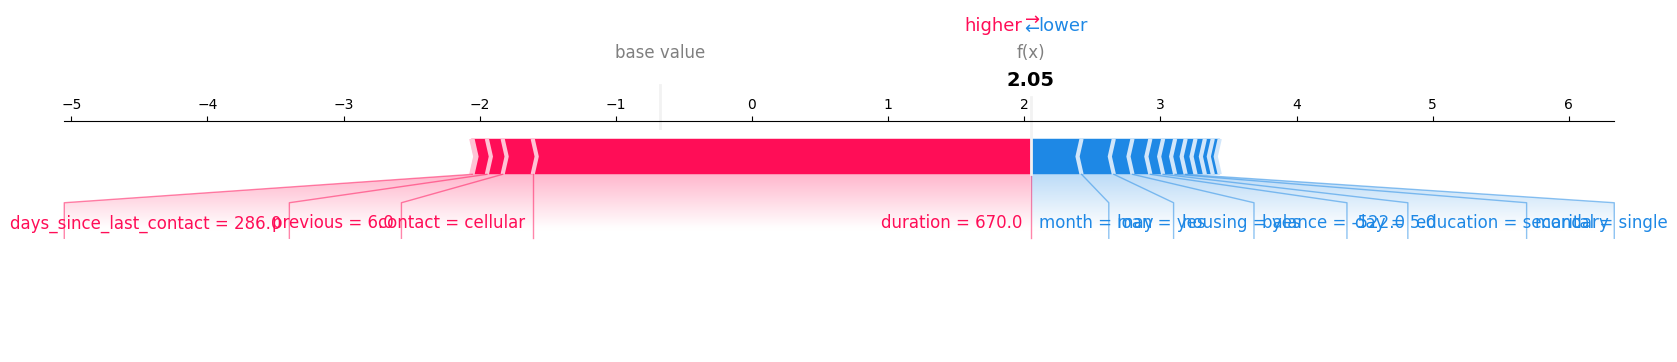

In [36]:


# Create a CatBoost explainer using the trained model
# Extract the CatBoost classifier from the pipeline
cat_model = best_model.named_steps['classifier']

feature_names_correct = cat_cols + num_cols

# Generate the SHAP explainer (TreeExplainer works well with CatBoost)
explainer = shap.TreeExplainer(cat_model)

# Get the dataset preprocessed by the pipeline for X_test
X_test_preprocessed = best_model.named_steps['preprocessor'].transform(X_test)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_preprocessed)

# Global feature importance
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names_correct)


# Select a specific customer, for example, the first one in the test set
shap.force_plot(
    explainer.expected_value,
    shap_values[0],            # SHAP values for customer 0
    X_test_preprocessed[0],    # Real values for customer 0
    feature_names=feature_names_correct, # <--- THIS IS THE KEY
    matplotlib=True            # Render as a static image
)

Let's do a few comments on this graphic. First of all, note that the Y axis represents the importance of each variable. The higher a variable is, the more important it is. As a result, we conclude that the most important one is duration, followed by month and contact, which are the same ones we obtained for the analysis of variable importance in trees. Meanwhile, the X axis indicates how positively or negatively is an observation to influde on the deposit outcome, meaning that the more to the left an observation is, the more likely to predict NO and the more the right, the more likely to predict YES.

As for the color palette, red tones indicate a high value on a fixed variable, while blue tones indicate low values. Some variables appear in gray because they do not have such a thing like "low values" or "high values". For example, the variable month is in gray since it does not admit a clear ordering. You cannot say that February is bigger than April for example.

In the bottom of the graphic, it appears what is called a force plot, which basically is the prediction for a single individual. In summary, it takes into account the values of all the variables for this concrete individual and makes a prediction. In this case, it obtains a positive value of 2.05, which means that the prediction will be YES for this individual.